In [28]:

import matplotlib.pyplot as plt
import math
from PIL import Image
import torch
import numpy as np
import random
import cv2
import torchvision

In [29]:
def randpoint():
    g,degree=random.choice([(32,10)])
    source=[]
    h=0
    while h<=256:
        w=0
        while w<=256:
            source.append([h,w])
            w+=g
        h+=g
    target=[]
    for i in range(len(source)):
        p=source[i]
        if p[0]==0 or p[0]==256 or p[1]==0 or p[1]==256:
            target.append([p[0],p[1]])
        else:
            noise1=random.randint(-degree,degree)
            noise2=random.randint(-degree,degree)
            target.append([source[i][0]+noise1,source[i][1]+noise2])
    source = np.array(source, np.int32)
    source = source.reshape(1, -1, 2)
    target = np.array(target, np.int32)
    target = target.reshape(1, -1, 2)
    return source,target


class TPS(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X, Y, w, h, device):
        """ 计算grid"""
        grid = torch.ones(1, h, w, 2, device=device)
        grid[:, :, :, 0] = torch.linspace(-1, 1, w)
        grid[:, :, :, 1] = torch.linspace(-1, 1, h)[..., None]
        grid = grid.view(-1, h * w, 2)

        """ 计算W, A"""
        n, k = X.shape[:2]
        device = X.device
        Z = torch.zeros(1, k + 3, 2, device=device)
        P = torch.ones(n, k, 3, device=device)
        L = torch.zeros(n, k + 3, k + 3, device=device)

        eps = 1e-9
        D2 = torch.pow(X[:, :, None, :] - X[:, None, :, :], 2).sum(-1)
        K = D2 * torch.log(D2 + eps)
        P[:, :, 1:] = X
        Z[:, :k, :] = Y
        L[:, :k, :k] = K
        L[:, :k, k:] = P
        L[:, k:, :k] = P.permute(0, 2, 1)

        Q = torch.solve(Z, L)[0]
        W, A = Q[:, :k], Q[:, k:]

        """ 计算U """
        eps = 1e-9
        D2 = torch.pow(grid[:, :, None, :] - X[:, None, :, :], 2).sum(-1)
        U = D2 * torch.log(D2 + eps)

        """ 计算P """
        n, k = grid.shape[:2]
        device = grid.device
        P = torch.ones(n, k, 3, device=device)
        P[:, :, 1:] = grid

        # grid = P @ A + U @ W
        grid = torch.matmul(P, A) + torch.matmul(U, W)
        return grid.view(-1, h, w, 2)

def norm(points_int, width, height,DEVICE):
	"""
	将像素点坐标归一化至 -1 ~ 1
    """
	points_int_clone = torch.from_numpy(points_int).detach().float().to(DEVICE)
	x = ((points_int_clone * 2)[..., 0] / (width - 1) - 1)
	y = ((points_int_clone * 2)[..., 1] / (height - 1) - 1)
	return torch.stack([x, y], dim=-1).contiguous().view(-1, 2)




In [30]:


img='image_file'
img = Image.open(img)
img=np.array(img)
DEVICE = torch.device("cuda",0)
ten_img = torchvision.transforms.ToTensor()(img).to(DEVICE)
ten_imgs=ten_img.repeat(16,1,1,1)


tps = TPS()



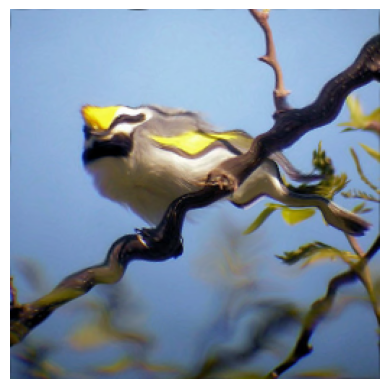

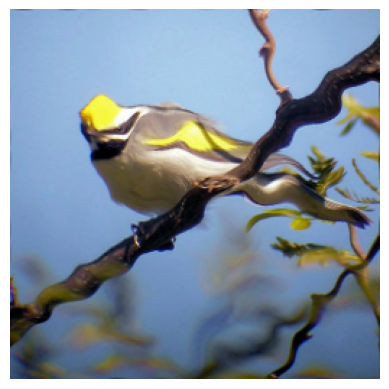

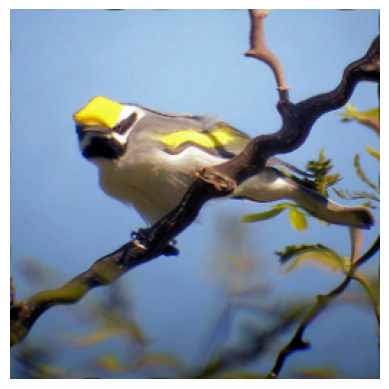

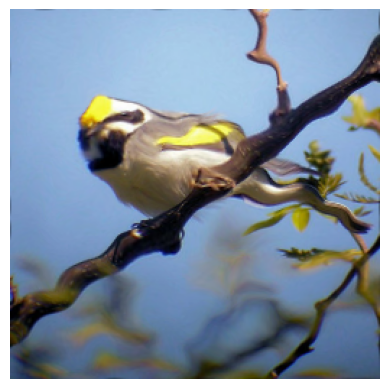

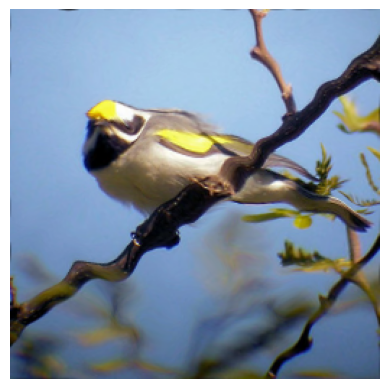

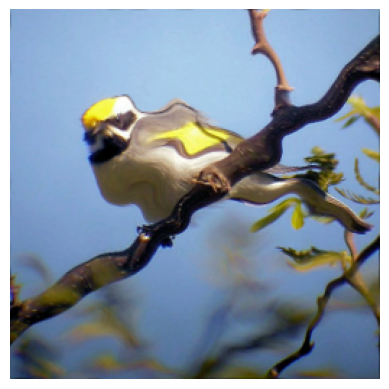

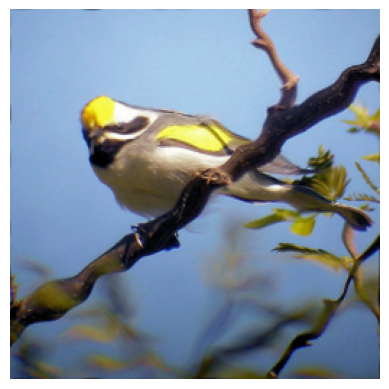

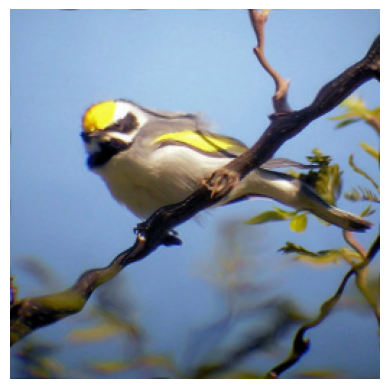

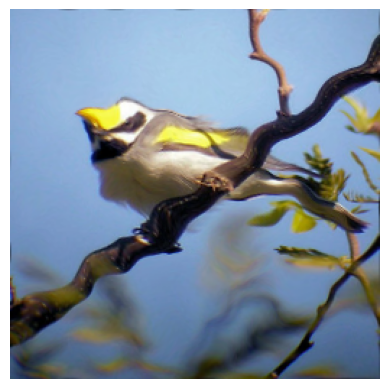

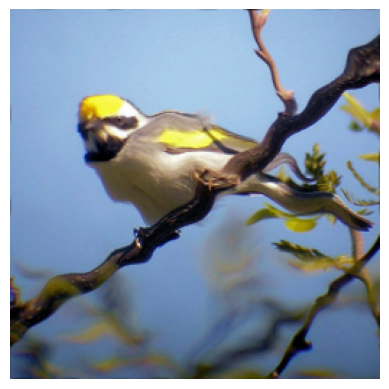

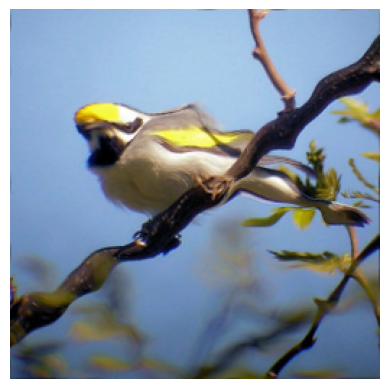

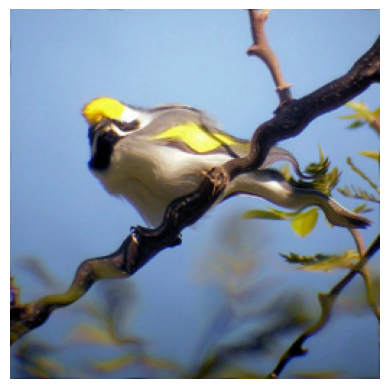

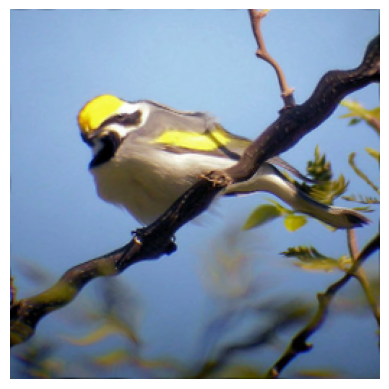

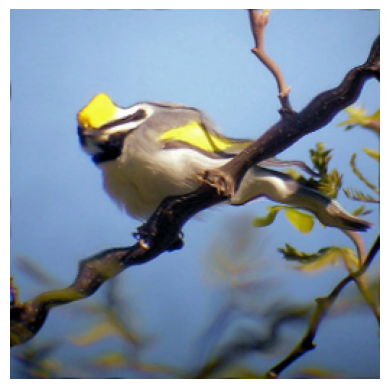

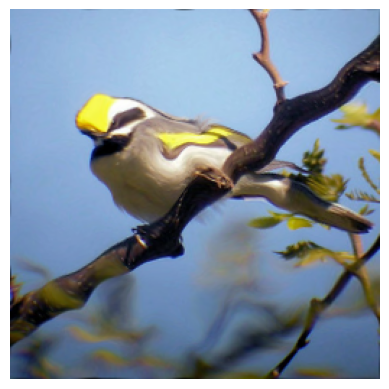

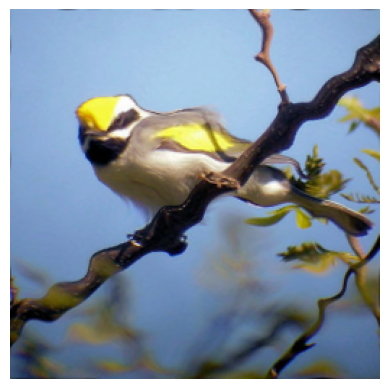

In [31]:
for ten_img in ten_imgs:
    source,target=randpoint1()
    h, w = ten_img.shape[1], ten_img.shape[2]
    ten_source = norm(source, w, h,DEVICE)
    ten_target = norm(target, w, h,DEVICE)

    warped_grid = tps(ten_target[None, ...], ten_source[None, ...], w, h, DEVICE)   #这个输入的位置需要归一化，所以用norm
    ten_wrp = torch.grid_sampler_2d(ten_img[None, ...], warped_grid, 0, 0,True)
    ten_img = np.array(torchvision.transforms.ToPILImage()(ten_wrp[0].cpu()))

    plt.imshow(ten_img)
    plt.axis('off')
    plt.show()

    